In [ ]:
%%bash

pip install gdown
apt install subversion
svn checkout https://github.com/HSE-LAMBDA/DeepGenerativeModels/trunk/homework/2-GAN
pip install edict
pip install wandb
wandb login ee9416edde558c322450d0ec80266d2c0db81f45

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 29 not upgraded.
Need to get 2,237 kB of archives.
After this operation, 9,910 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libserf-1-1 amd64 1.3.9-6 [44.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libsvn1 amd64 1.9.7-4ubuntu1 [1,183 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/universe amd64 subversion amd64 1.9.7-4ubuntu1 [834 kB]
Fetch



wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Важно:

Пожалуйста, поддерживайте ваш код в хорошем состоянии, пишите комментарии, убирайте бесполезные ячейки, пишите модели в специально отведенных модулях. Проверяющие могут **НА СВОЕ УСМОТРЕНИЕ** снижать баллы за:

1. Говнокод
2. Неэффективные решения
3. Вермишель из ячеек в тетрадке
4. Все остальное что им не понравилось


## Важно 2 (0 - 0.15 балла):

За использование логгеров типа wandb/comet/neptune и красивую сборку этой домашки в виде графиков/картинок в этих логгерах мы будем выдавать бонусные баллы.



## Важно 3:

Решением домашки является архив с использованными тетрадками/модулями, а так же **.pdf файл** с отчетом по проделанной работе по каждому пункту задачи. 
В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать штуки которые вы использовали (например дополнительные лоссы для стабилизации, WGAN-GP, а не GAN/WGAN+clip)


In [ ]:
import wandb
import numpy as np
import torchvision

import torch
from torch import nn
from torch.nn import functional as F
from easydict import EasyDict as edict

from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Subset


import matplotlib.pyplot as plt
from utils import filter_idx, permute_labels, seed_all

SEED = 1992

В этом домашнем задании мы будем работать с Celeba. Celeba - это уже известный вам датасет состоящий из фотографий селеб в их привычной местности:

In [ ]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [ ]:
import gdown
url = 'https://drive.google.com/uc?id=1p8YKs8uczGWj8lmHVhak-bNTNxdXbKBb'
output = 'celeba.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1p8YKs8uczGWj8lmHVhak-bNTNxdXbKBb
To: /content/celeba.zip
2.73GB [00:35, 76.0MB/s]


'celeba.zip'

In [ ]:
!rm -r /content/celeba

rm: cannot remove '/content/celeba': No such file or directory


In [ ]:
%%bash

unzip -q /content/celeba.zip
rm -r /content/celeba/celeba/img_align_celeba
unzip -q /content/celeba/celeba/img_align_celeba.zip
mv /content/img_align_celeba /content/celeba/celeba/img_align_celeba

In [ ]:
b_sz = 32
celeba_train = torchvision.datasets.CelebA('./celeba', target_type='attr', transform=transforms, split="train", download=False)
celeba_val = torchvision.datasets.CelebA('./celeba', target_type='attr', transform=transforms, split="valid", download=False)

In [ ]:
index2attr = {i:j for i, j in enumerate(celeba_train.attr_names)}

In [ ]:
ATTRIBUTES = ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']
ATTRIBUTE_IDX = [k for k, v in index2attr.items() if v in ATTRIBUTES]
print(ATTRIBUTE_IDX)

[8, 9, 11, 20, 39]


In [ ]:
train_filtered = filter_idx(celeba_train, ATTRIBUTE_IDX[:3])
val_filtered = filter_idx(celeba_val, ATTRIBUTE_IDX[:3])
celeba_train = Subset(celeba_train, indices=train_filtered)
celeba_val = Subset(celeba_val, indices=val_filtered)
celeba_train_dataloader = torch.utils.data.DataLoader(celeba_train, b_sz, shuffle=True)
celeba_val_dataloader = torch.utils.data.DataLoader(celeba_val, b_sz, shuffle=False, drop_last=True)

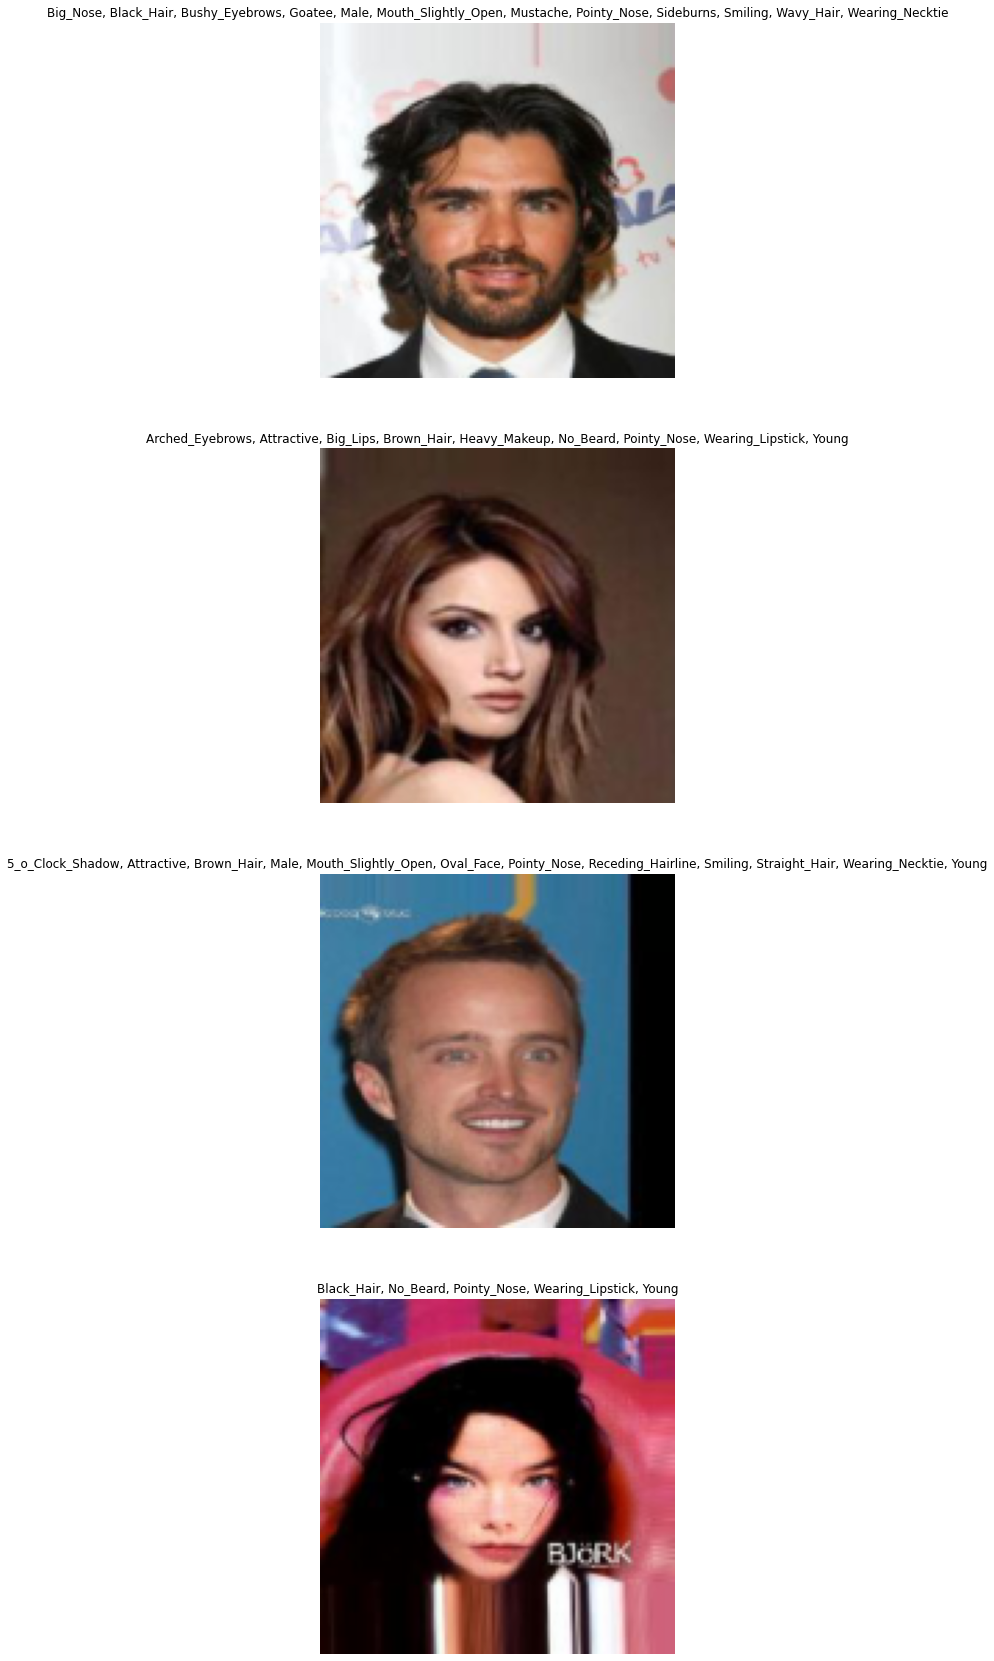

In [ ]:
n_img = 4
plt.figure(figsize=(30, 30))
for index, (image, attr) in enumerate(celeba_val):
    if index >= n_img: break
    plt.subplot(n_img, 1, index+1)
    plt.imshow((image.squeeze().permute(1, 2, 0) + 1) / 2)
    plt.title(', '.join([index2attr[att_i] for att_i, att_val in enumerate(attr.view(-1)) if att_val == 1]))
    plt.axis('off')

plt.show()

In [ ]:
print(len(celeba_train_dataloader) * b_sz, len(celeba_val_dataloader))

94464 365


# Training

В этой домашней работе вам предлагается повторить результаты статьи StarGAN (https://arxiv.org/abs/1711.09020). 

Основная часть домашнего задания - чтение статьи и улучшение результатов, поэтому обязательно прочитайте не только StarGAN, но и другие Image-to-Image GAN подходы того времени (17-18 год) 


## Задача 1 (0.4 балла):

Повторить результаты StarGAN используя только CelebA

что это значит: в статье предлагается способ использовать несколько датасетов и выучивание аттрибутов уникальных для какого-то одного датасета. Мы не просим вас это делать, вам достаточно просто обучить StarGAN на CelebA

In [ ]:
def get_text_label(label):
    text_label = " ".join(index2attr[i] for i, lbl in zip(ATTRIBUTE_IDX, label) if lbl)
    return text_label

def log_images(n_img, dataloader):
      image, label = next(iter(dataloader))
      b_sz = image.size(0)
      label = label[:, ATTRIBUTE_IDX] 
      new_label = permute_labels(label)
      real_image = (image + 1) / 2
      real_image = real_image.numpy()
      fake_image = model.generate(image.to(device), new_label.to(device)).cpu().numpy()
      fake_image = (fake_image + 1) / 2
      wandb.log({'epoch': epoch,
                  'real images': [
                  wandb.Image(real_image[i].transpose(1, 2, 0), caption=f"real {get_text_label(label[i])}") 
                  for i in range(b_sz)],
                  'fake images': [
                  wandb.Image(fake_image[i].transpose(1, 2, 0), caption=f"fake {get_text_label(new_label[i])}") 
                  for i in range(b_sz)]})

In [ ]:
import sys
from fid import calculate_fid, make_inception_feature_extractor
sys.path.append('/content/2-GAN')
from model import StarGAN
from config import make_config

seed_all(SEED)
config = make_config()
device = config.device
model = StarGAN(config)
model.to(device)
classifier = make_inception_feature_extractor(device)
wandb.init(project='gen models hw2', name=f'StarGAN high lr')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [ ]:
epochs = 15
log_step, gen_step = 100, 5
for epoch in range(epochs):
    model.train()
    for step, (image, label) in enumerate(tqdm(celeba_train_dataloader, leave=False, desc=f"trainloop: {epoch}")):
      label = label[:, ATTRIBUTE_IDX]
      image = image.to(device)
      label = label.to(device)

      model.trainD(image, label)
      model.trainG(image, label)     

      if step % log_step == 0:   
          log_images(n_img, celeba_val_dataloader)
    log_images(n_img, celeba_val_dataloader)
    wandb.log({'fid': calculate_fid(celeba_val_dataloader, model, classifier, device, ATTRIBUTE_IDX)})
    torch.save({'G_state_dict': model.G.state_dict(), 'D_state_dict': model.D.state_dict() 
               }, 'checkpoint.pt')





fid:   0%|          | 0/365 [00:00<?, ?it/s]



fid:   0%|          | 1/365 [00:00<01:56,  3.12it/s]



fid:   1%|          | 2/365 [00:00<01:59,  3.03it/s]



fid:   1%|          | 3/365 [00:01<01:59,  3.02it/s]



fid:   1%|          | 4/365 [00:01<01:58,  3.06it/s]



fid:   1%|▏         | 5/365 [00:01<01:59,  3.02it/s]



fid:   2%|▏         | 6/365 [00:01<01:56,  3.07it/s]



fid:   2%|▏         | 7/365 [00:02<01:56,  3.06it/s]



fid:   2%|▏         | 8/365 [00:02<01:56,  3.06it/s]



fid:   2%|▏         | 9/365 [00:02<01:57,  3.04it/s]



fid:   3%|▎         | 10/365 [00:03<01:58,  2.99it/s]



fid:   3%|▎         | 11/365 [00:03<01:52,  3.16it/s]



fid:   3%|▎         | 12/365 [00:03<01:45,  3.34it/s]



fid:   4%|▎         | 13/365 [00:04<01:41,  3.46it/s]



fid:   4%|▍         | 14/365 [00:04<01:39,  3.54it/s]



fid:   4%|▍         | 15/365 [00:04<01:36,  3.61it/s]



fid:   4%|▍         | 16/365 [00:04<01:36,  3.62it/s]



fid:   5%|▍         | 17/365 [00:05<01:35,  3





fid:   0%|          | 0/365 [00:00<?, ?it/s]



fid:   0%|          | 1/365 [00:00<01:49,  3.34it/s]



fid:   1%|          | 2/365 [00:00<01:51,  3.25it/s]



fid:   1%|          | 3/365 [00:00<01:55,  3.13it/s]



fid:   1%|          | 4/365 [00:01<01:56,  3.11it/s]



fid:   1%|▏         | 5/365 [00:01<01:57,  3.07it/s]



fid:   2%|▏         | 6/365 [00:01<01:54,  3.12it/s]



fid:   2%|▏         | 7/365 [00:02<01:54,  3.14it/s]



fid:   2%|▏         | 8/365 [00:02<01:52,  3.16it/s]



fid:   2%|▏         | 9/365 [00:02<01:55,  3.09it/s]



fid:   3%|▎         | 10/365 [00:03<01:55,  3.07it/s]



fid:   3%|▎         | 11/365 [00:03<02:00,  2.94it/s]



fid:   3%|▎         | 12/365 [00:03<01:58,  2.98it/s]



fid:   4%|▎         | 13/365 [00:04<02:00,  2.93it/s]



fid:   4%|▍         | 14/365 [00:04<01:59,  2.93it/s]



fid:   4%|▍         | 15/365 [00:04<01:56,  3.00it/s]



fid:   4%|▍         | 16/365 [00:05<01:54,  3.06it/s]



fid:   5%|▍         | 17/365 [00:05<01:49,  3





fid:   0%|          | 0/365 [00:00<?, ?it/s]



fid:   0%|          | 1/365 [00:00<01:49,  3.33it/s]



fid:   1%|          | 2/365 [00:00<01:53,  3.21it/s]



fid:   1%|          | 3/365 [00:00<01:54,  3.17it/s]



fid:   1%|          | 4/365 [00:01<01:54,  3.16it/s]



fid:   1%|▏         | 5/365 [00:01<01:56,  3.10it/s]



fid:   2%|▏         | 6/365 [00:01<02:01,  2.97it/s]



fid:   2%|▏         | 7/365 [00:02<02:00,  2.96it/s]



fid:   2%|▏         | 8/365 [00:02<02:02,  2.90it/s]



fid:   2%|▏         | 9/365 [00:03<02:03,  2.89it/s]



fid:   3%|▎         | 10/365 [00:03<02:01,  2.92it/s]



fid:   3%|▎         | 11/365 [00:03<02:05,  2.83it/s]



fid:   3%|▎         | 12/365 [00:04<02:05,  2.82it/s]



fid:   4%|▎         | 13/365 [00:04<02:01,  2.89it/s]



fid:   4%|▍         | 14/365 [00:04<02:02,  2.87it/s]



fid:   4%|▍         | 15/365 [00:05<02:01,  2.89it/s]



fid:   4%|▍         | 16/365 [00:05<01:59,  2.91it/s]



fid:   5%|▍         | 17/365 [00:05<01:57,  2





fid:   0%|          | 0/365 [00:00<?, ?it/s]



fid:   0%|          | 1/365 [00:00<01:44,  3.50it/s]



fid:   1%|          | 2/365 [00:00<01:49,  3.31it/s]



fid:   1%|          | 3/365 [00:00<01:51,  3.25it/s]



fid:   1%|          | 4/365 [00:01<01:53,  3.19it/s]



fid:   1%|▏         | 5/365 [00:01<01:55,  3.13it/s]



fid:   2%|▏         | 6/365 [00:01<01:54,  3.12it/s]



fid:   2%|▏         | 7/365 [00:02<01:53,  3.15it/s]



fid:   2%|▏         | 8/365 [00:02<01:52,  3.18it/s]



fid:   2%|▏         | 9/365 [00:02<01:52,  3.16it/s]



fid:   3%|▎         | 10/365 [00:03<01:51,  3.17it/s]



fid:   3%|▎         | 11/365 [00:03<01:53,  3.11it/s]



fid:   3%|▎         | 12/365 [00:03<01:54,  3.09it/s]



fid:   4%|▎         | 13/365 [00:04<01:55,  3.05it/s]



fid:   4%|▍         | 14/365 [00:04<01:55,  3.03it/s]



fid:   4%|▍         | 15/365 [00:04<01:55,  3.03it/s]



fid:   4%|▍         | 16/365 [00:05<01:57,  2.97it/s]



fid:   5%|▍         | 17/365 [00:05<01:55,  3





fid:   0%|          | 0/365 [00:00<?, ?it/s]



fid:   0%|          | 1/365 [00:00<01:59,  3.05it/s]



fid:   1%|          | 2/365 [00:00<01:58,  3.06it/s]



fid:   1%|          | 3/365 [00:01<02:00,  3.00it/s]



fid:   1%|          | 4/365 [00:01<01:59,  3.01it/s]



fid:   1%|▏         | 5/365 [00:01<01:58,  3.04it/s]



fid:   2%|▏         | 6/365 [00:01<01:57,  3.06it/s]



fid:   2%|▏         | 7/365 [00:02<02:00,  2.97it/s]



fid:   2%|▏         | 8/365 [00:02<01:59,  2.99it/s]



fid:   2%|▏         | 9/365 [00:03<01:58,  2.99it/s]



fid:   3%|▎         | 10/365 [00:03<02:00,  2.96it/s]



fid:   3%|▎         | 11/365 [00:03<01:57,  3.01it/s]



fid:   3%|▎         | 12/365 [00:03<01:54,  3.07it/s]



fid:   4%|▎         | 13/365 [00:04<01:54,  3.07it/s]



fid:   4%|▍         | 14/365 [00:04<01:56,  3.01it/s]



fid:   4%|▍         | 15/365 [00:04<01:55,  3.03it/s]



fid:   4%|▍         | 16/365 [00:05<01:55,  3.03it/s]



fid:   5%|▍         | 17/365 [00:05<01:52,  3

In [ ]:
import random
model.eval()
device = config.device

num_img = 8
val_dataloader = torch.utils.data.DataLoader(celeba_val, num_img, shuffle=True, drop_last=True)

fig, axs = plt.subplots(num_img, 6, figsize=(60,100))
 
batch = next(iter(val_dataloader))
titles = ['Black Hair', 'Blond Hair', 'Brown Hair', 'Invert Gender', 'Invert Age']
for ind, (image, label) in enumerate(zip(*batch)):  
    label = np.array(label, dtype=float)[ATTRIBUTE_IDX]
    axs[ind, 0].imshow((image.permute(1, 2, 0) + 1) / 2, aspect='auto')
    axs[ind, 0].axis("off")
    if ind == 0:
        axs[ind, 0].set_title('Original', fontsize=50)
    
    for i in range(5):
        title = titles[i]
        new_label = label.copy()
        new_label[:3] = 0.
        new_label[i] = 1.0 - new_label[i]
        new_label = torch.Tensor(new_label)
        fake_image = model.generate(image.to(device).unsqueeze(0), new_label.to(device).unsqueeze(0)).cpu()[0]
        axs[ind, i + 1].imshow((fake_image.permute(1, 2, 0) + 1) / 2, aspect='auto')
        axs[ind, i + 1].axis("off")
        
        if ind == 0:
            axs[ind, i + 1].set_title(title, fontsize=50)
        
plt.subplots_adjust(hspace=0.02, wspace=0.02)    
plt.show()

## Важно 4: 

Если вы учите на колабе или на наших машинках, вероятнее всего что обучение будет очень долгим на картинках 256х256. Никто не мешает уменьшить разрешение, главное чтобы было видно что трансформации выучились

Еще, кажется что не все аттрибуты селебы являются очень важными или достаточно представленными в датасете. Не запрещается убирать бесполезные аттрибуты (только обоснуйте почему так сделали в отчете)

Не забывайте про аугментации

## Важно 5: 

Да, мы знаем что в на гитхабе лежит готовый код на путорче для этой статьи. Проблема в том что он написал на torch 0.4, поэтому, если мы увидим что вы используете __старый__ код со старыми модулями, то мы:

1. Будем неодобрительно смотреть
2. За наглое списывание будем снимать баллы


## Задача 2 (0.2 балла): 

Мерить качество на глаз - плохая идея. Подключите подсчет FID для каждой N эпохи, чтобы вы могли следить за прогрессом модели.

Сранение моделей между собой тоже возможно только по FID, поэтому трекайте его когда будете делать другие эксперименты

## Задача 3 (0.4 балла):

Если вы будете дословно повторять архитектуру авторов статьи, вы сразу же увидите что обучение станет дико долгим и не очень стабильным. Возможно у вас получится предложить несколько улучшений, которые приведут к хорошему FID, к визуально лучшим результатам или к более стабильному обучению.

В этой задаче хочется чтобы вы попробовали улучшить результаты статьи используя либо то что уже знаете, либо что-то из релевантных статей по Im2Im современности

## Важно 6: 

Когда вы будете показывать визуальные трансформации которые делает ваш StarGAN, хорошей идеей будет сразу же зафиксировать набор картинок (очевидно из валидации) и набор трансформаций на которых вы будете показывать результаты. Например: 10 картинок разных людей на которых вы покажете Male-Female, Beard-noBeard, Old-Young трансформации

## Важно 7 (0.15 балла): 

Выдам дополнительные баллы если у вас получится визуально красивая перекраска волос в разные цвета